In [1]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

train_a = pd.read_csv('C:/Users/kari.abromitis/Desktop/Data Science/train_a_final.csv')
train_b = pd.read_csv('C:/Users/kari.abromitis/Desktop/Data Science/train_b_final.csv')
train_c = pd.read_csv('C:/Users/kari.abromitis/Desktop/Data Science/train_c_final.csv')

# print(train_a)

train_b = train_b.drop(['period','Day','Hour','Unnamed: 0','Minute_x_x','Second_x_x', 'Minute_y_x', 'Second_y_x', 'Minute_x_y',  'Second_x_y',  'Minute_y_y', 'Second_y_y'], axis=1)
train_b = train_b[['dst','bt_mean', 'density_mean', 'speed_mean', 'temp_mean', 'bt_std','density_std', 'speed_std', 'temp_std', 'smoothed_ssn']]
print(train_b)


       dst    bt_mean  density_mean  speed_mean      temp_mean    bt_std  \
0       13  19.855536     13.192679  405.649643   62334.607143  1.292524   
1        3  20.073860     11.779825  395.844211  109488.947368  0.546122   
2      -38  16.321786     17.190000  409.880357  182935.125000  1.658582   
3      -73  19.601786      8.746071  410.188036  154476.946429  0.785119   
4     -103  19.188305      9.922881  417.753051  160721.779661  0.653429   
...    ...        ...           ...         ...            ...       ...   
51883  -11   2.257167      2.248833  403.731667   38948.150000  0.058108   
51884  -10   1.807333      2.103833  381.133333   40481.800000  0.165313   
51885   -9   1.838000      2.008500  371.680000   41300.950000  0.117974   
51886   -5   1.971333      1.603500  375.338333   38206.850000  0.195444   
51887   -3   2.116167      1.384667  377.120000   36783.666667  0.130801   

       density_std  speed_std      temp_std  smoothed_ssn  
0         4.443074  15.0966

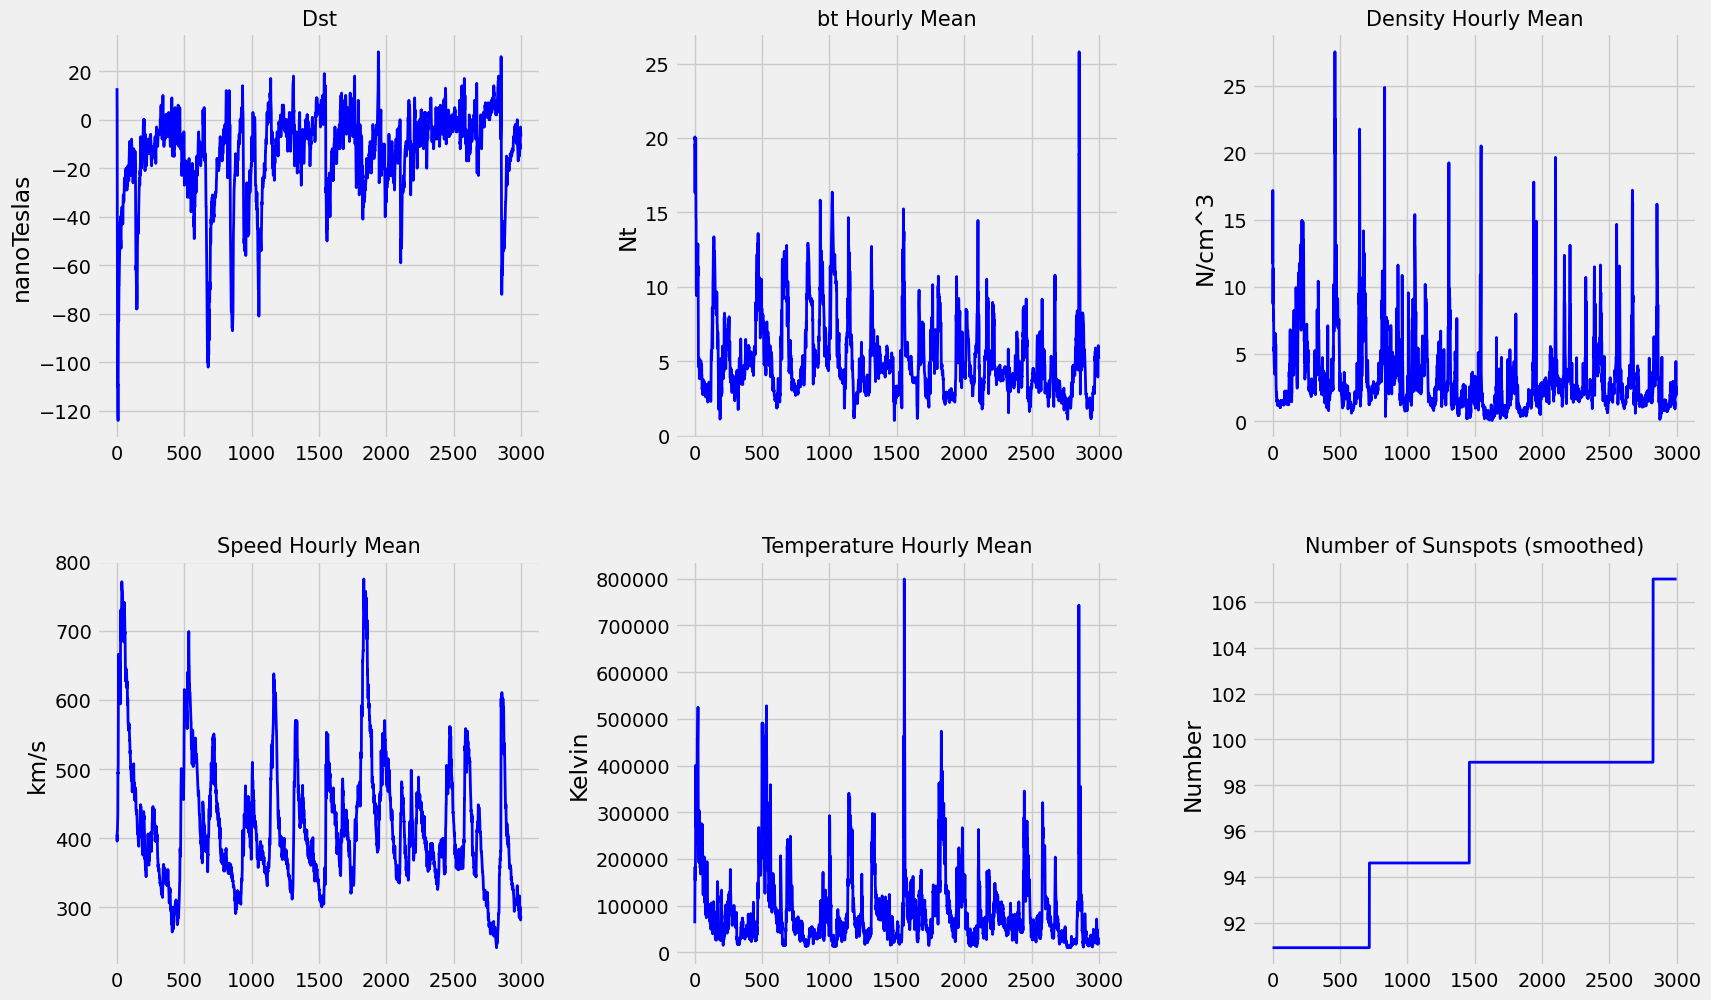

In [51]:
# Change the figure size
plt.figure(figsize=[20, 20])

plt.subplots_adjust(left=0.13, right=0.93, top=1.0, bottom= 0.27, wspace= 0.3, hspace=0.3)


# Plot 1
plt.subplot(3, 3, 1)
plt.plot(train_b['dst'].iloc[:3000],'b', linewidth=2)
plt.title('Dst', fontsize=15)
plt.ylabel('nanoTeslas')

# Plot 2
plt.subplot(3, 3, 2)
plt.plot(train_b['bt_mean'].iloc[:3000],'b', linewidth=2)
plt.title('bt Hourly Mean', fontsize=15)
plt.ylabel('Nt')

# Plot 3
plt.subplot(3, 3, 3)
plt.plot(train_b['density_mean'].iloc[:3000],'b', linewidth=2)
plt.title('Density Hourly Mean', fontsize=15)
plt.ylabel('N/cm^3')

# Plot 4
plt.subplot(3, 3, 4)
plt.plot(train_b['speed_mean'].iloc[:3000],'b', linewidth=2)
plt.title('Speed Hourly Mean', fontsize=15)
plt.ylabel('km/s')

# Plot 5
plt.subplot(3, 3, 5)
plt.plot(train_b['temp_mean'].iloc[:3000],'b', linewidth=2)
plt.title('Temperature Hourly Mean', fontsize=15)
plt.ylabel('Kelvin')

# Plot 6
plt.subplot(3, 3, 6)
plt.plot(train_b['smoothed_ssn'].iloc[:3000],'b', linewidth=2)
plt.title('Number of Sunspots (smoothed)', fontsize=15)
plt.ylabel('Number')



plt.show()

In [99]:


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = train_b
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)
# print(reframed.head())

print(reframed)

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.836879   0.557581   0.152392   0.219626   0.024646   0.121652   
2       0.801418   0.563900   0.136056   0.206490   0.044230   0.051401   
3       0.656028   0.455313   0.198608   0.225294   0.074733   0.156105   
4       0.531915   0.550238   0.100981   0.225706   0.062914   0.073895   
5       0.425532   0.538272   0.114587   0.235841   0.065507   0.061500   
...          ...        ...        ...        ...        ...        ...   
51883   0.751773   0.047361   0.025232   0.223451   0.016577   0.015439   
51884   0.751773   0.048277   0.025861   0.217056   0.014933   0.005469   
51885   0.755319   0.035259   0.024184   0.186781   0.015570   0.015559   
51886   0.758865   0.036147   0.023082   0.174117   0.015910   0.011104   
51887   0.773050   0.040005   0.018399   0.179018   0.014625   0.018395   

       var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)   var1(t)  
1       0.091963   0.047230   0.0255

In [116]:
# split into train and test sets

values = reframed.values
n_train_hours = round(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



(41489, 1, 10) (41489,) (10372, 1, 10) (10372,)


Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 150)               96600     
                                                                 
 dense_36 (Dense)            (None, 1)                 151       
                                                                 
Total params: 96,751
Trainable params: 96,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
433/433 - 3s - loss: 0.0700 - accuracy: 2.4103e-05 - val_loss: 0.0236 - val_accuracy: 0.0000e+00 - 3s/epoch - 7ms/step
Epoch 2/5
433/433 - 1s - loss: 0.0323 - accuracy: 4.8206e-05 - val_loss: 0.0193 - val_accuracy: 0.0000e+00 - 1s/epoch - 3ms/step
Epoch 3/5
433/433 - 1s - loss: 0.0275 - accuracy: 4.8206e-05 - val_loss: 0.0171 - val_accuracy: 0.0000e+00 - 1s/epoch - 3ms/step
Epoch 4/5
433/433 - 2s - loss: 0.0254 - accuracy: 4.8206e-

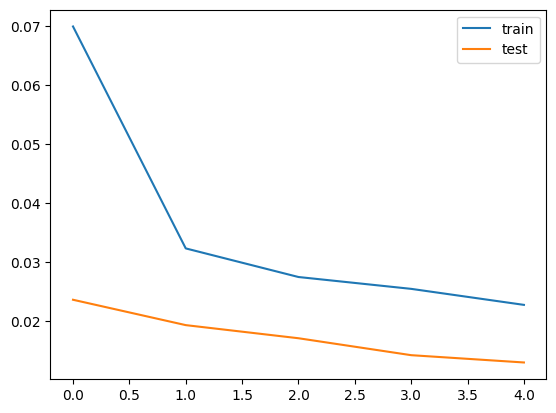

In [117]:

# design network
model = Sequential()
model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2]), dropout = 0.01))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
model.summary()

# model.summary()
# fit network
history = model.fit(train_X, train_y, epochs=5, batch_size=96, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()



In [118]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

325/325 [==============================] - 1s 1ms/step
Test RMSE: 4.608


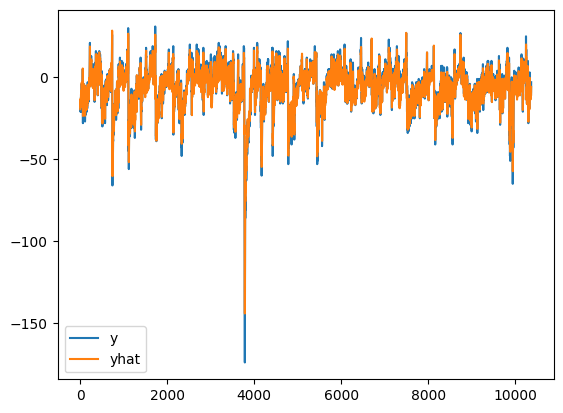

In [109]:
# pyplot.plot(inv_y, inv_yhat)
plt.plot(inv_y, label='y')
plt.plot(inv_yhat, label='yhat')
plt.legend()
plt.show()
plt.show()